In [84]:
import pandas as pd

In [85]:
train_data = pd.read_csv("../minicomp-rossman/data/train.csv").reset_index(drop=True)
store_data = pd.read_csv("../minicomp-rossman/data/store.csv").reset_index(drop=True)

/Users/sinarampe/opt/anaconda3/envs/mini_comp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
train_data.Date = pd.to_datetime(train_data.Date)
train_data.head(4)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [87]:
def add_time_features(df):
    df['Year'] = df.Date.dt.year - 2013
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['WeekOfYear'] = df.Date.dt.isocalendar().week.astype(int)
    df = df.drop(labels = "Date", axis=1)
    return df

In [88]:
def drop_nans_nulls_closed(df):
    df = df[df["Open"]==1]
    df = df[df["Sales"]!=0]
    df = df.dropna(subset = ["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday", "Sales"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    return df

In [89]:
def drop_cols(df):
    df = df.drop(labels = ["Customers"], axis=1)
    return df

In [90]:
train_data = add_time_features(train_data)
train_data = drop_nans_nulls_closed(train_data)
train_data = drop_cols(train_data)

In [91]:
merged_train = pd.merge(train_data, store_data, how='left', on="Store")

In [92]:
merged_train.shape

(439929, 20)

In [93]:
def recode(df, var_list=[]):
    map_dict = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df

In [94]:
merged_train = recode(merged_train, ['StoreType', 'Assortment', 'StateHoliday'])

In [95]:
train = merged_train.iloc[:int(0.9*train_data.shape[0]), :]
eva = merged_train.iloc[int(0.9*train_data.shape[0]):int(0.95*train_data.shape[0]), :]
test = merged_train.iloc[int(0.95*train_data.shape[0]):, :]

In [96]:
import xgboost as xgb
from xgboost import plot_importance

In [97]:
target = 'Sales'

feat_dict = {'only_time' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Open'],
             'only_comp' : ['CompetitionDistance', 'Promo2', 'Open', 'Promo'],
             'only_store' : ['StoreType', 'Assortment', 'Open'],
             'all_feat' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
                           'CompetitionDistance', 'Promo2', 'StoreType', 'Assortment', 'Open', 'Promo']}

In [98]:
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }

In [99]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def compute_rmse(actual, prediction):
    """
    Computs RMSE (root mean squared error) between predictions from a model
    and the actual values of the target variable.
    """
    
    rmse = sqrt(mean_squared_error(actual, prediction))
    
    # rounding to 2 decimal places
    print('RMSE is ', round(rmse,2))
    
    return rmse

In [100]:
def xgboost_experiment(vars_list, experiment_name, params, num_boost_round):
    dtrain = xgb.DMatrix(train[vars_list], label=train['Sales'], enable_categorical=True)
    deva = xgb.DMatrix(eva[vars_list], label=eva['Sales'])
    dtest = xgb.DMatrix(test[vars_list], label=test['Sales'], enable_categorical=True)
    
    #train
    xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, 
                      early_stopping_rounds=100, evals=[(deva, "Eval")], verbose_eval=False)

    # make prediction
    print('+++++ Results for experiment: ', experiment_name)
    pred = xgb_model.predict(dtest)
    print("Testerror")
    print(compute_rmse(test[target], pred) / test[target].mean())
    pred = xgb_model.predict(dtrain)
    print("Trainerror")
    compute_rmse(train[target], pred) 
    return xgb_model

In [101]:
for f in feat_dict.keys():
    xgboost_experiment(feat_dict[f], f, params, 10)

+++++ Results for experiment:  only_time
Testerror
RMSE is  2841.2
0.39987722406257065
Trainerror
RMSE is  2744.66


+++++ Results for experiment:  only_comp
Testerror
RMSE is  2574.55
0.36234825613971255
Trainerror
RMSE is  2548.47


+++++ Results for experiment:  only_store
Testerror
RMSE is  3124.98
0.43981676325714436
Trainerror
RMSE is  3017.14


+++++ Results for experiment:  all_feat
Testerror
RMSE is  2487.88
0.3501503816378751
Trainerror
RMSE is  2404.07


In [ ]:
num_boost_round_list = [100, 1000]

for n in num_boost_round_list:
    print('### Experiment with ', str(n), ' boosting rounds')
    xgboost_experiment(feat_dict['all_feat'], f, params, n)

### Experiment with  100  boosting rounds
+++++ Results for experiment:  all_feat
Testerror
RMSE is  1716.48
0.2415809337098308
Trainerror
RMSE is  1530.42


### Experiment with  1000  boosting rounds
+++++ Results for experiment:  all_feat
Testerror
RMSE is  1444.5
0.2033023173685384
Trainerror
RMSE is  1059.2


### Experiment with  4000  boosting rounds


In [82]:
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.05,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "seed": 10                
          }

In [83]:
model1 = xgboost_experiment(feat_dict['all_feat'], 'test with different hyperparameters', params, 1000)

[11:03:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

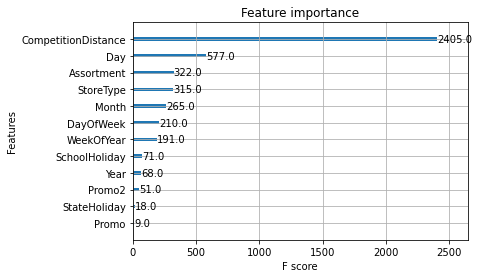

In [34]:
plot_importance(model1)